<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting04_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk — Meeting 4
### Correlated Normals, Cholesky, Copulas (intro), and M/G/1 Queue Simulation

**Goals**
- Generate correlated normal vectors using Cholesky and connect to last week’s loss modeling.
- Estimate VaR/TVaR for a portfolio with many correlated normals.
- See a hands-on Gaussian copula demonstration.
- Simulate a queue with general service times (M/G/1), e.g., Uniform service.


> **Parameters** — edit and then run the notebook top-to-bottom.

In [53]:
import numpy as np, math, matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['axes.grid']=True

# Seed for reproducibility
SEED = 1729
rng = np.random.default_rng(SEED)

# Portfolio settings for VaR/TVaR demo
V0 = 2_000_000.0
n_assets = 20
mu = 0.0004                      # daily mean per asset
sigma = 0.02                     # daily vol per asset
rho = 0.9                       # common correlation
alpha = 0.99                     # risk level (VaR/TVaR)
N_PATHS = 100_000

print(f"Seed={SEED}, assets={n_assets}, mu={mu}, sigma={sigma}, rho={rho}, alpha={alpha}, N={N_PATHS:,}")


Seed=1729, assets=20, mu=0.0004, sigma=0.02, rho=0.9, alpha=0.99, N=100,000


## A) Cholesky example for correlated normals
We form a covariance (or correlation) matrix, take its Cholesky factor $L$, draw independent normals $Z$, and set $X = L \times Z$ to obtain correlated normals.

In [54]:
# Build an n×n correlation matrix with pairwise rho
n = 5
Sigma = np.full((n,n), rho); np.fill_diagonal(Sigma, 1.0)

# Cholesky factor L such that Sigma = L @ L.T
L = np.linalg.cholesky(Sigma)

# Draw independent normals Z and correlate: X = L @ Z
m = 50_000
Z = rng.standard_normal((n, m))          # each column ~ iid N(0,I)
X = L @ Z                                 # correlated normals with corr ~ Sigma

# Quick empirical check of correlations (should be near rho off-diagonal)
emp_corr = np.corrcoef(X)
print("Target rho:", rho)
print("Empirical off-diagonal mean corr:", (emp_corr[~np.eye(n, dtype=bool)]).mean())


Target rho: 0.9
Empirical off-diagonal mean corr: 0.8993067037412373


*Ponder:* what does Sigma look like?

In [55]:
print(Sigma)

[[1.  0.9 0.9 0.9 0.9]
 [0.9 1.  0.9 0.9 0.9]
 [0.9 0.9 1.  0.9 0.9]
 [0.9 0.9 0.9 1.  0.9]
 [0.9 0.9 0.9 0.9 1. ]]


## B) VaR and TVaR with many correlated normals
We model asset returns as a multivariate normal with equal correlations and compute portfolio loss from a weighted sum; then estimate VaR and TVaR (ES) by Monte Carlo.

VaR@0.99=$87,816  TVaR/ES=$100,495


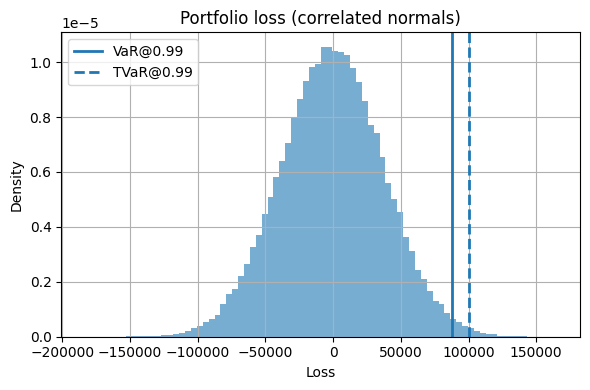

In [56]:
# Equal weights for simplicity
w = np.ones(n_assets)/n_assets

# Build correlation matrix and Cholesky for n_assets
Sigma_full = np.full((n_assets,n_assets), rho); np.fill_diagonal(Sigma_full, 1.0)
L_full = np.linalg.cholesky(Sigma_full)

# Simulate correlated standard normals -> returns with mu, sigma
Z = rng.standard_normal((n_assets, N_PATHS))
Zc = L_full @ Z
R = mu + sigma * Zc                    # asset-level returns
Rp = (w[:,None] * R).sum(axis=0)       # portfolio return
Loss = -V0 * Rp

VaR_mc = float(np.quantile(Loss, alpha))
ES_mc  = float(Loss[Loss >= VaR_mc].mean())
print(f"VaR@{alpha:.2f}=${VaR_mc:,.0f}  TVaR/ES=${ES_mc:,.0f}")

plt.figure()
plt.hist(Loss, bins=80, density=True, alpha=0.6)
plt.axvline(VaR_mc, linewidth=2, label=f"VaR@{alpha:.2f}")
plt.axvline(ES_mc, linestyle='--', linewidth=2, label=f"TVaR@{alpha:.2f}")
plt.title("Portfolio loss (correlated normals)")
plt.xlabel("Loss"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()


VaR@0.99=$19,854  TVaR/ES=$22,952


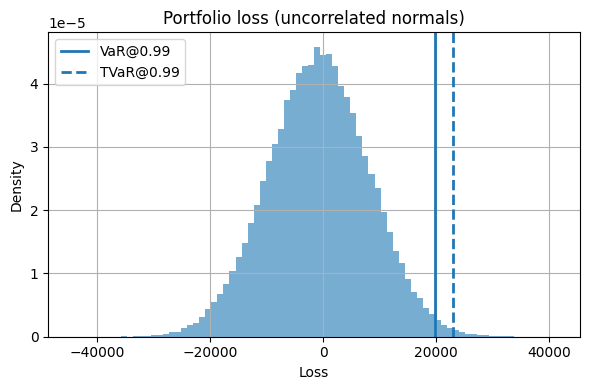

In [57]:
# Equal weights for simplicity
w = np.ones(n_assets)/n_assets

# Build correlation matrix and Cholesky for n_assets
Sigma_full = np.full((n_assets,n_assets), 0); np.fill_diagonal(Sigma_full, 1.0) #note the change from rho to 0
L_full = np.linalg.cholesky(Sigma_full)

# Simulate independent standard normals -> returns with mu, sigma
Z = rng.standard_normal((n_assets, N_PATHS))
Zc = L_full @ Z
R = mu + sigma * Zc                    # asset-level returns
Rp = (w[:,None] * R).sum(axis=0)       # portfolio return
Loss = -V0 * Rp

VaR_mc = float(np.quantile(Loss, alpha))
ES_mc  = float(Loss[Loss >= VaR_mc].mean())
print(f"VaR@{alpha:.2f}=${VaR_mc:,.0f}  TVaR/ES=${ES_mc:,.0f}")

plt.figure()
plt.hist(Loss, bins=80, density=True, alpha=0.6)
plt.axvline(VaR_mc, linewidth=2, label=f"VaR@{alpha:.2f}")
plt.axvline(ES_mc, linestyle='--', linewidth=2, label=f"TVaR@{alpha:.2f}")
plt.title("Portfolio loss (uncorrelated normals)")
plt.xlabel("Loss"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()


*Ponder:* What are the differences between the plots?

## C) Copulas demonstration (Gaussian copula)
We first create correlated uniforms via a Gaussian copula (correlate normals, apply Φ to get uniforms), then map uniforms into non-normal marginals with inverse CDFs (here: Lognormal and Exponential as examples).

Compare to an example with no correlation and with high tail correlation.

Empirical corr between transformed marginals: 0.8806169419850087


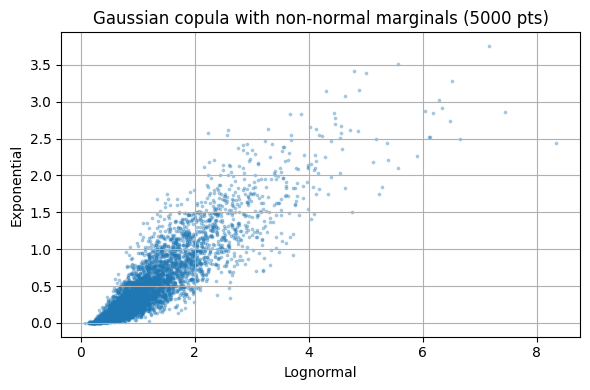

In [58]:
from scipy.stats import norm

# Step 1: correlated normals for 2 variables
rho_cop = 0.9
Sigma2 = np.array([[1.0, rho_cop],[rho_cop, 1.0]])
L2 = np.linalg.cholesky(Sigma2)

Z = rng.standard_normal((2, N_PATHS))
Zc = L2 @ Z

# Step 2: apply Φ to get correlated U(0,1) uniforms
U = norm.cdf(Zc)

# Step 3: map uniforms to chosen marginals
mu_l, sigma_l = 0.0, 0.6
X_logn = np.exp(mu_l + sigma_l * norm.ppf(U[0]))

lambda_e = 2.0
Y_exp = -np.log(1 - U[1]) / lambda_e

print("Empirical corr between transformed marginals:",
      np.corrcoef(X_logn, Y_exp)[0,1])

plt.figure()
plt.scatter(X_logn[:5000], Y_exp[:5000], s=3, alpha=0.3)
plt.title("Gaussian copula with non-normal marginals (5000 pts)")
plt.xlabel("Lognormal"); plt.ylabel("Exponential"); plt.tight_layout(); plt.show()


In the block below, we show that the probability both are large is slightly greater than $(0.05)^2 = .0025$.

In [59]:
q = 0.95
xq, yq = np.quantile(X_logn, q), np.quantile(Y_exp, q)
p_joint = np.mean((X_logn >= xq) & (Y_exp >= yq))
print(f"P(X & Y both above {int(q*100)}th pct): {p_joint:.3%}")


P(X & Y both above 95th pct): 3.181%


Below is another measure of correlation, Spearman Rank Correlation.

In [60]:
from scipy.stats import spearmanr
sr = spearmanr(X_logn, Y_exp).correlation

print("Spearman rho =", round(sr, 3))

Spearman rho = 0.892


Independent Example

INDEPENDENT: Spearman rho = 0.002 | P(both >= 95th pct) = 0.280%


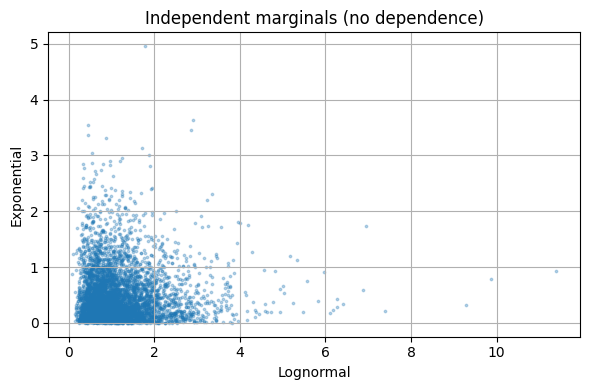

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

rng = np.random.default_rng(2025)
N = 50_000

# Marginals (same as your demo): Lognormal and Exponential
mu_l, sigma_l = 0.0, 0.6
X_ind = np.exp(mu_l + sigma_l * rng.standard_normal(N))  # Lognormal
lambda_e = 2.0
Y_ind = rng.exponential(1/lambda_e, size=N)              # Exponential

# Diagnostics
sr = spearmanr(X_ind, Y_ind).correlation
qx, qy = np.quantile(X_ind, 0.95), np.quantile(Y_ind, 0.95)
p_joint = np.mean((X_ind >= qx) & (Y_ind >= qy))

print("INDEPENDENT: Spearman rho =", round(sr, 3),
      "| P(both >= 95th pct) =", f"{p_joint:.3%}")

plt.figure()
plt.scatter(X_ind[:5000], Y_ind[:5000], s=3, alpha=0.3)
plt.title("Independent marginals (no dependence)")
plt.xlabel("Lognormal"); plt.ylabel("Exponential"); plt.tight_layout(); plt.show()


Tail correlation example

t-COPULA (nu=4): Spearman rho = 0.88 | P(both >= 95th pct) = 3.402%


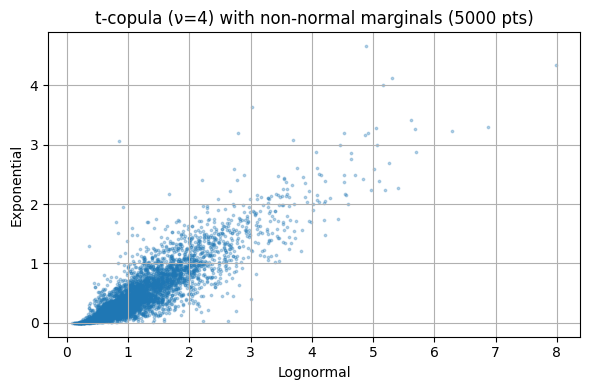

In [62]:
import numpy as np, math
import matplotlib.pyplot as plt
from scipy.stats import t, norm, spearmanr

rng = np.random.default_rng(2025)
N = 50_000
rho = 0.9          # target linear correlation in the latent space
nu  = 4            # degrees of freedom (smaller nu => heavier tails)

# Step 1: correlated Student-t in 2D (scale both normals with the SAME chi-square shock)
L = np.array([[1.0, 0.0],
              [rho, math.sqrt(1 - rho**2)]])
Z = rng.standard_normal((2, N))
W = rng.chisquare(df=nu, size=N)
Zc = L @ Z / np.sqrt(W/nu)       # 2×N draws from bivariate t_nu with corr ~ rho

# Step 2: map to uniforms via t CDF (this *is* the t-copula)
U = t.cdf(Zc, df=nu)

# Step 3: send uniforms to your marginals
mu_l, sigma_l = 0.0, 0.6
X_t = np.exp(mu_l + sigma_l * norm.ppf(U[0]))              # Lognormal
lambda_e = 2.0
Y_t = -np.log(1 - U[1]) / lambda_e                         # Exponential

# Diagnostics
sr = spearmanr(X_t, Y_t).correlation
qx, qy = np.quantile(X_t, 0.95), np.quantile(Y_t, 0.95)
p_joint = np.mean((X_t >= qx) & (Y_t >= qy))

print("t-COPULA (nu=4): Spearman rho =", round(sr, 3),
      "| P(both >= 95th pct) =", f"{p_joint:.3%}")

plt.figure()
plt.scatter(X_t[:5000], Y_t[:5000], s=3, alpha=0.3)
plt.title("t-copula (ν=4) with non-normal marginals (5000 pts)")
plt.xlabel("Lognormal"); plt.ylabel("Exponential"); plt.tight_layout(); plt.show()


## D) Queueing with a general distribution (M/G/1 with Uniform service)
We simulate Poisson arrivals (rate λ) and Uniform(a,b) service times to illustrate an M/G/1 queue and examine waiting times.

Sample mean Wq=0.4498  W=0.6490  (λ=4.0, Uniform(0.1,0.3))


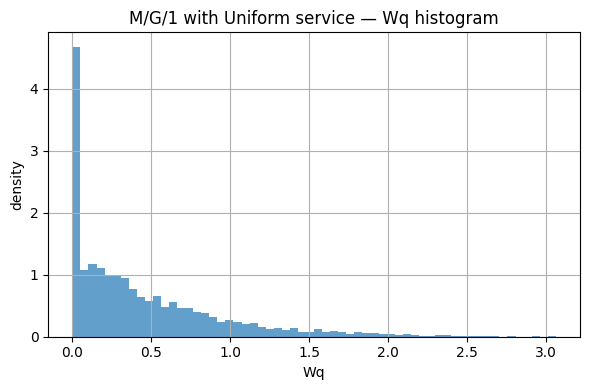

In [63]:
def simulate_MG1_uniform_service(N, lam, a, b, rng):
    inter = rng.exponential(1/lam, size=N)
    service = rng.uniform(a, b, size=N)
    arrival = np.cumsum(inter)
    start = np.empty(N); finish = np.empty(N)
    start[0] = arrival[0]; finish[0] = start[0] + service[0]
    for i in range(1, N):
        start[i] = max(arrival[i], finish[i-1])
        finish[i] = start[i] + service[i]
    Wq = start - arrival; W = finish - arrival
    return Wq, W

lam = 4.0; a, b = 0.10, 0.30
Nq = 5000
Wq, W = simulate_MG1_uniform_service(Nq, lam, a, b, rng)
print(f"Sample mean Wq={Wq.mean():.4f}  W={W.mean():.4f}  (λ={lam}, Uniform({a},{b}))")

plt.figure(); plt.hist(Wq, bins=60, density=True, alpha=0.7)
plt.title("M/G/1 with Uniform service — Wq histogram")
plt.xlabel("Wq"); plt.ylabel("density"); plt.tight_layout(); plt.show()


*Ponder:* what is the difference between $E[W_q]$ and $E[W]$?

## Homework (turn in your Colab copy)
1) **Correlation sensitivity:** For ρ ∈ {0.0, 0.2, 0.4, 0.6, 0.8}, recompute VaR/TVaR for the many-asset portfolio. Plot VaR and TVaR vs ρ and write two sentences interpreting the trend.

**Explanation:**
<font color="#00FFFF">  
The plots of VaR and TVaR vs rho show that the value at risk and tail value at risk increase as the correlation between assets increases. The increased correlation will result in extreme occurances having a bigger impact on the portfolio.

In [92]:
# Equal weights for simplicity
import pandas as pd
df = []

w = np.ones(n_assets)/n_assets

p = [0, 0.2, 0.4, 0.6, 0.8]
VaRs_list = []
ES_list = []

for rho in p:

# Build correlation matrix and Cholesky for n_assets
  Sigma_full = np.full((n_assets,n_assets), rho); np.fill_diagonal(Sigma_full, 1.0)
  L_full = np.linalg.cholesky(Sigma_full)

# Simulate correlated standard normals -> returns with mu, sigma
  Z = rng.standard_normal((n_assets, N_PATHS))
  Zc = L_full @ Z
  R = mu + sigma * Zc                    # asset-level returns
  Rp = (w[:,None] * R).sum(axis=0)       # portfolio return
  Loss = -V0 * Rp

  VaR_mc = float(np.quantile(Loss, alpha))
  ES_mc  = float(Loss[Loss >= VaR_mc].mean())

  VaRs_list.append(VaR_mc)
  ES_list.append(ES_mc)

data = np.vstack([p, VaRs_list, ES_list]).T
df = pd.DataFrame(data, columns=['rho', 'VaR', 'ES'])

df.head()

,rho,VaR,ES
0,0.0,3.822394e+06,3.915050e+06
1,0.2,4.570563e+06,4.778801e+06
2,0.4,5.023634e+06,5.288270e+06
3,0.6,5.403536e+06,5.715556e+06
4,0.8,5.723091e+06,6.083431e+06


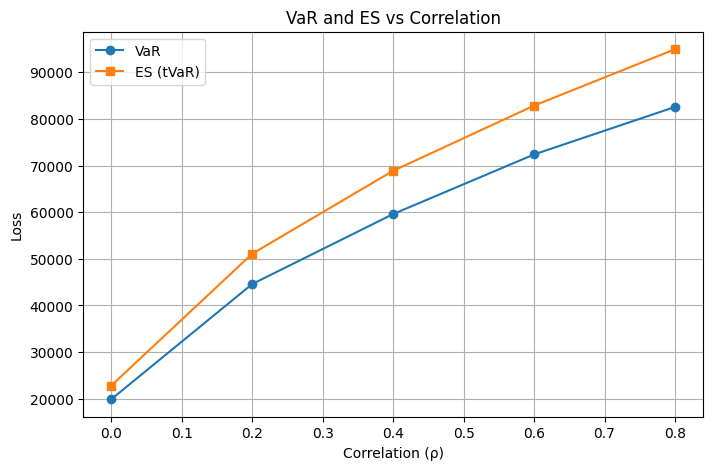

In [65]:

# Plot VaR and ES against rho
plt.figure(figsize=(8,5))
plt.plot(df["rho"], df["VaR"], marker='o', label="VaR")
plt.plot(df["rho"], df["ES"], marker='s', label="ES (tVaR)")

plt.xlabel("Correlation (ρ)")
plt.ylabel("Loss")
plt.title("VaR and ES vs Correlation")
plt.legend()
plt.grid(True)
plt.show()


2) **Copula marginals:** Replace the lognormal/exponential marginals with (a) a discrete distribution and (b) a continuous distribution. Keep the same Gaussian copula correlation; show a scatter and report the empirical Spearman rank correlation. Explain tail behavior in two sentences.

**Explanation:**
<font color="#00FFFF">  
The marginals determine each variable's tail heaviness individually, the copla determines whether extreme values occur together. The Gaussian copla has no tail dependence so joint extremes are unlikely even if marginals have heavy tails.

The scatter plot shows the lack of Gaussian copla tail dependence, we can see there are relatively few extreme results.

Empirical corr between transformed marginals: 0.8884256608152502


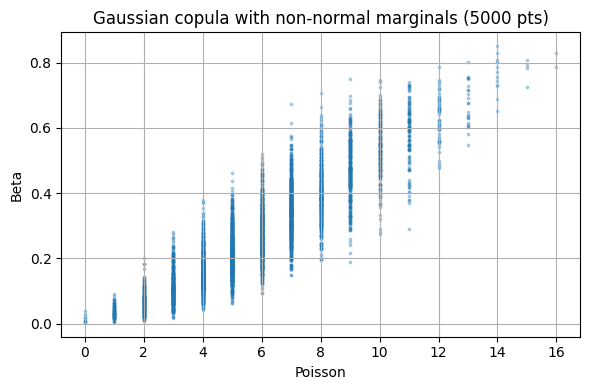

In [66]:
from scipy.stats import norm, poisson, beta

# Step 1: correlated normals for 2 variables
rho_cop = 0.9
Sigma2 = np.array([[1.0, rho_cop],[rho_cop, 1.0]])
L2 = np.linalg.cholesky(Sigma2)

Z = rng.standard_normal((2, N_PATHS))
Zc = L2 @ Z

# Step 2: apply Φ to get correlated U(0,1) uniforms
U = norm.cdf(Zc)

# Step 3a, map uniforms to discrete poisson
lam_pois = 6.0
X_pois = poisson.ppf(U[0], mu=lam_pois)

# Step 3b, map uniforms to continous beta
a_b, b_b = 2.0, 5.0
Y_beta = beta.ppf(U[1], a=a_b, b=b_b)

print("Empirical corr between transformed marginals:",
      np.corrcoef(X_pois, Y_beta)[0,1])

plt.figure()
plt.scatter(X_pois[:5000], Y_beta[:5000], s=3, alpha=0.3)
plt.title("Gaussian copula with non-normal marginals (5000 pts)")
plt.xlabel("Poisson"); plt.ylabel("Beta"); plt.tight_layout(); plt.show()

3) **Queueing variant:** Change the service-time distribution to a general distribution and compare mean and shape of the Wq histogram to the Uniform case. Include one plot and 3–4 explanatory sentences.

**Explanation:**
<font color="#00FFFF">  
Below I compared the Wq service time histograms of the Uniform(0.1,0.3) and Lognormal(μ=-1.60, σ=0.60).
<font color="#00FFFF">  
The Uniform case is narrowly spread and has a tall spike near 0, this makes sense because uniform service times are more conecentrated and cause fewer long queues. The lognormal case produced a much flatter histogram with a long right tail. The lognormal queue time has a higher mean due to greater variance in service times.

Both the service distributions have approximately the same mean but the waiting time behavior is very different due to the differing variability.

Sample mean Wq=3.2447  W=3.4834  (λ=4, mu=-1.6, sigma=0.6))
Sample mean Wq=0.4288  W=0.6286  (λ=4, Uniform(0.1,0.3))


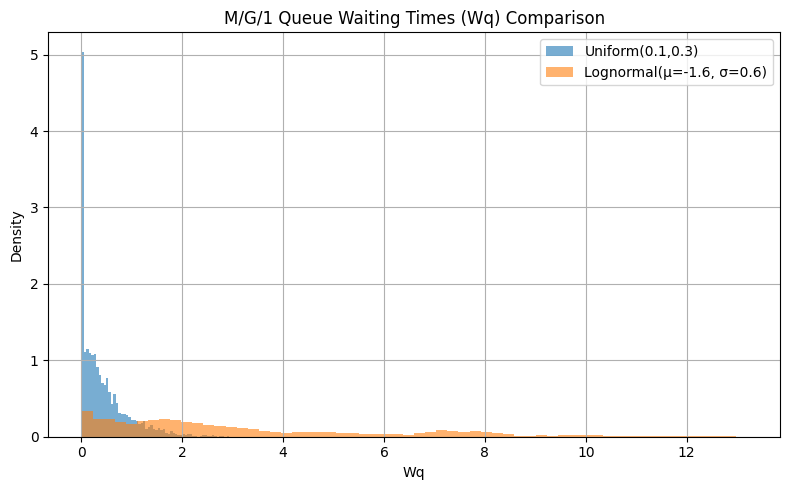

In [87]:
from scipy.stats import lognorm

def simulate_MG1_lognorm_service(N, lam, rng,mu,sigma):
    inter = rng.exponential(1/lam, size=N)

    # service = rng.uniform(a, b, size=N)
    service = rng.lognormal(mu, sigma, size=N)
    arrival = np.cumsum(inter)

    start = np.empty(N); finish = np.empty(N)
    start[0] = arrival[0]; finish[0] = start[0] + service[0]
    for i in range(1, N):
        start[i] = max(arrival[i], finish[i-1])
        finish[i] = start[i] + service[i]
    Wq = start - arrival; W = finish - arrival
    return Wq, W

Nq = 5000
mu, sigma = -1.6, 0.6
lam = 4
Wq_logn, W_logn = simulate_MG1_lognorm_service(Nq, lam, rng, mu, sigma)
print(f"Sample mean Wq={Wq_logn.mean():.4f}  W={W_logn.mean():.4f}  (λ={lam}, mu={mu}, sigma={sigma}))")

Wq_uni, W_uni = simulate_MG1_uniform_service(Nq, lam, a, b, rng)
print(f"Sample mean Wq={Wq_uni.mean():.4f}  W={W_uni.mean():.4f}  (λ={lam}, Uniform({a},{b}))")

plt.figure(figsize=(8,5))
plt.hist(Wq_uni, bins=60, density=True, alpha=0.6, label=f"Uniform({a},{b})")
plt.hist(Wq_logn, bins=60, density=True, alpha=0.6, label=f"Lognormal(μ={mu}, σ={sigma})")
plt.title("M/G/1 Queue Waiting Times (Wq) Comparison")
plt.xlabel("Wq")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

4. **Grading Each Other:** Share your answers to Week 3 homework part 2 (about advanced queueing systems). Comment on their technique and compare to your own technique.

Asher <-> Chuoyue

Lucian <-> Moises

Momin <-> Praneet

**Explanation:**
<font color="#00FFFF">  
Chuoyue and I both modeled M/M/c queues. Our techniques were very similar, we both created an array to keep track of the servers availible times and used the min function to choose which server is ready soonest and the max function to find when to start service.
<font color="#00FFFF">  
There were some slight differences in our code for calculating the theoretical results. To compare our methods I chose the same parameters (Seed, server count, mu, lambda and N) for our models and found that we got the exact same values for Wq, W, and our graphs were identical.
<font color="#00FFFF">  
Overall, our techniques were very similar and accomplished the same goal.

